# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK', 'ADD YOUR CODE HERE', and 'QUESTION'.

In [46]:
username = 'pascutc98'
repo = 'ai-in-medicine-practical2'

!git clone https://github.com/{username}/{repo}

# Only run this cell when in Google Colab
# ! git init
# ! git remote add origin https://github.com/compai-lab/aim-practical-2-brain-segmentation.git
# ! git fetch
# ! git checkout -t origin/main

Cloning into 'ai-in-medicine-practical2'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [ ]:
%cd ai-in-medicine-practical2
%ls

[Errno 2] No such file or directory: 'ai-in-medicine-practical2'
/content/ai-in-medicine-practical2
data_utils.py  plot_utils.py  README.md  segmentation_main.ipynb  utils.py


## Downloading the Data

In [ ]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip

brainage-data.zip   100%[===================>] 446.94M  17.5MB/s    in 27s     
brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      


## Imports

In [ ]:
from argparse import Namespace

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from tqdm import tqdm
import os
import glob

from data_utils import load_nii, load_segmentations
from plot_utils import plot_segmentations
from utils import seed_everything, TensorboardLogger
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

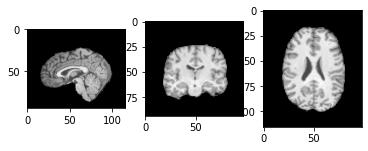

In [ ]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3)
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [ ]:
# Returns a list of files that matches the path specified in the function argument (glob.glob)
paths = sorted(glob.glob('data/brain_age/segs_refs/*')) 
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:04<00:00, 140.44it/s]


In [ ]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], [] 
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 86579.06it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample 

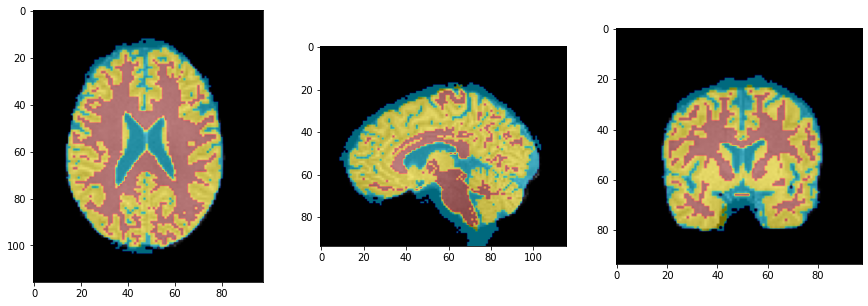

In [ ]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47)

# Task 1: Evaluation: TASK

We first have to define how good our predicted segmentations are. Implement the evaluation function below. 

In [ ]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms and measures the intersection over union of predicted segmentations to ground truth
# Implement a method that computes the patient-wise Dice score (mean and std) for the test dataset
# --------------------------- ADD YOUR CODE HERE ------------------------------

def Dice(predictions, gt): #gt is ground truth
  dice_score = np.zeros(predictions.shape[0])

  for i in range(0, predictions.shape[0]):
    numerator = 2 * np.sum(predictions[:,:,i] == gt[:,:,i])
    denominator = np.sum(predictions[:,:,i]) + np.sum(gt[:,:,i])

    dice_score[i] = numerator / denominator
  
  mean = np.mean(dice_score)
  std = np.std(dice_score)

  return mean, std
  
# ----------------------------------- END -------------------------------------

# Task 2: Unsupervised segmentation 

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored. 

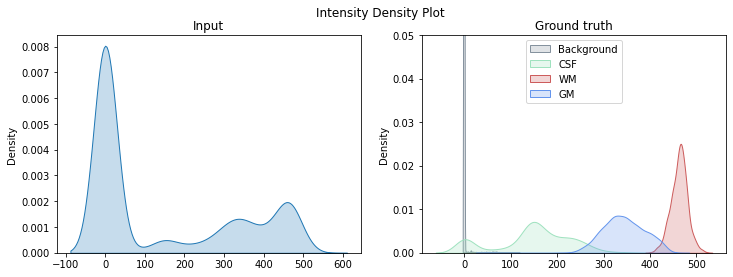

In [ ]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

# Gaussian mixtures

(98, 116)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(11368, 1)
(11368,)


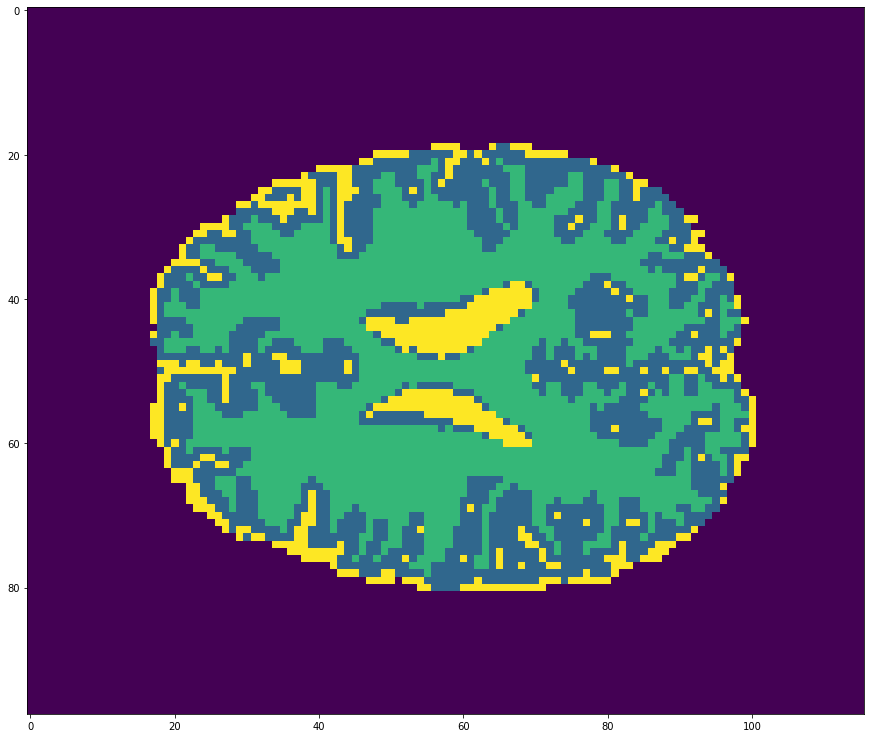

In [59]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import cv2


medical_image = load_nii(train_files[slice_id])[:,:,47]
print(np.shape(medical_image))
#plt.imshow(medical_image, cmap="gray")
print(medical_image)

vectorized = medical_image.reshape((-1,1))
print(np.shape(vectorized))

# vectorized = np.float32(vectorized)
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# K = 4
# attempts=10
# ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
# center = np.uint8(center)

# res = center[label.flatten()]
# result_image = res.reshape((medical_image.shape))

# figure_size = 15
# plt.figure(figsize=(figure_size,figure_size))
# plt.subplot(1,2,1),plt.imshow(medical_image)
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,2,2),plt.imshow(result_image)
# plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
# plt.show()




kmeans = KMeans(n_clusters=4, random_state=0).fit(vectorized)
print(np.shape(kmeans.labels_))
result_kmeans = np.reshape(kmeans.labels_, (98,116))

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.imshow(result_kmeans)

## Unsupervised Learning: TASK

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

HINT: You can predict the different classes of intensities even without any training!

HINT: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

### QUESTION Q1: What is the most intuitve segmentation approach? (based on the intensity density plot of the input)
Hint: What distibution best describes the intensity density plot above? 

### QUESTION Q2: Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1. What results do you get? 

In [ ]:
# Unsupervised method 1 
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the validations set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_1 = None 
# ----------------------------------- END -------------------------------------

### QUESTION Q3: Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2. What results do you get? 

In [ ]:
# Unsupervised method 2 
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the validations set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_2 = None 
# ----------------------------------- END -------------------------------------

### QUESTION Q4: Which approach worked better? Why? 

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations. 

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background] 
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation: TASK

Define and train a neural network for segmentation below (use the train, val, and test splits defined above)

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [ ]:
# Define and train a neural network for segmentation
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_3 = None 
# ----------------------------------- END -------------------------------------

### QUESTION Q5: Evaluate the Dice scores (separately for every tissue type) for the whole test set.  What results do you get? 

In [ ]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# --------------------------- ADD YOUR CODE HERE ------------------------------
plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None
plt_gt = None  
# ----------------------------------- END -------------------------------------

### QUESTION Q6: Which of the three aproaches above (classical and DL) obtains better results? Why? 

### QUESTION Q7: What extra-information in the volumes is used by the DL models compared to the unsupervised approaches in Task 2? Why is it helpful? 